## benchmarks

In [87]:
import sys,os,shutil,subprocess
import glob,tempfile
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
sys.path.append('c:/Users/damien/projects/snipgenie/')
from snipgenie import tools, aligners, app, trees, plotting

In [42]:
testpath = '/storage/snipgenie_test_files/'

## create test files

In [ ]:
#use wicklow samples
path = '/storage/btbgenie/mbovis_ireland/Wicklow/'
df=app.get_samples(app.get_files_from_paths(path),'_')
df=df.sort_values('sample')

names = ['31-12952','13-11594','15-11643','17-11662','19-11957','44-MBovis']
for i,r in list(df.iterrows()):
    f = r.filename  
    if r['sample'] in names:
        #print (r)
        tools.get_subsample_reads(f,'/storage/snipgenie_test_files/',400000)
    

In [61]:
## trimming

In [ ]:
reload(app)
reload(tools)
reload(aligners)
args = {'threads':8, 'outdir': "bowtie_results", 'labelsep':'_',
        'input':[testpath],        
         'species': 'Mbovis-AF212297','get_stats':False,
         #'overwrite':True,
         'aligner':'bowtie',
         #'trim':True,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [53]:
sm1 = pd.read_csv('bwa_results/snpdist.csv',index_col=0)
sm2 = pd.read_csv('minimap2_results/snpdist.csv',index_col=0)
sm3 = pd.read_csv('subread_results/snpdist.csv',index_col=0)
#sm1

In [62]:
sm3

""


In [82]:
sm1.sub(sm2).abs()

,13-11594,15-11643,17-11662,19-11957,31-12952,44-MBovis
13-11594,0,2,0,2,1,0
15-11643,2,0,2,0,1,2
17-11662,0,2,0,2,1,0
19-11957,2,0,2,0,1,2
31-12952,1,1,1,1,0,1
44-MBovis,0,2,0,2,1,0


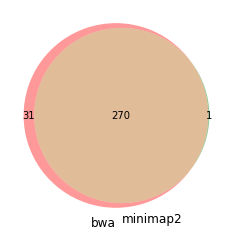

In [86]:
v1 = tools.vcf_to_dataframe('bwa_results/filtered.vcf.gz')
v2 = tools.vcf_to_dataframe('minimap2_results/filtered.vcf.gz')
from matplotlib_venn import venn2
a=list(v1.mut.unique())
b=list(v2.mut.unique())
venn2([set(a),set(b)],('bwa','minimap2'))